## 1. Import Modules and Data
BERT can be fine-tined on Stanford Sentiment Treebank-2(SST2) dataset for text classification task. More info about SST2 can be found [here](https://huggingface.co/datasets/stanfordnlp/sst2).

In [2]:
import torch
from transformers import BertTokenizer, AdamW
from data import load_data
from modules.bert import BERTTextClassifier, BertModel
import config 
# load sst-2
tokenizer, train_dataloader, valid_dataloader = load_data(
    name="sst2",
    loading_ratio=1,  # load 100% sst-2 data
    num_proc=4,  # use 4 processes
    splits=["train", "validation"]  # load train and validation dataset
)

# check one batch shape
for batch in train_dataloader:
    input_ids, attention_mask, labels = batch
    print(input_ids.shape, attention_mask.shape, labels.shape)
    break


torch.Size([32, 128]) torch.Size([32, 128]) torch.Size([32])


## 2. Build Model and Load from Pre-trained
Build a BERT text classification model which inherits from the BERT class and add a binary linear classification layer at the end of the structure.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")\
 
# load pretrained model
model = BERTTextClassifier.from_pretrained(
    model_name_or_path=config.pretrained_path,
    num_frozen_layers=0,  # frozen layer. Here do not froze
)
model = model.to(device)
print(model)


Number of trainable parameters: 109.48M
BERTTextClassifier(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): ModuleDict(
          (self): SelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ModuleDict(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
        )
   

## 3. Train Model

### 3.1 Optimizer and Scheduler
Original paper shows that they use Adam with learning rate of 1e-4, β1 = 0.9, β2 = 0.999, L2 weight decay of 0.01, learning rate warmup over the first 10,000 steps, and linear decay of the learning rate in the pretraining.

For fine-tuning, most model hyperparameters are the same as in pre-training, with the exception of the batch size, learning rate, and number of training epochs.
The dropout probability was always kept at 0.1. The optimal hyperparameter values are task-specific.

Here, the learning rate schedule is shown as below, and initial lr value is set as 4e-5.

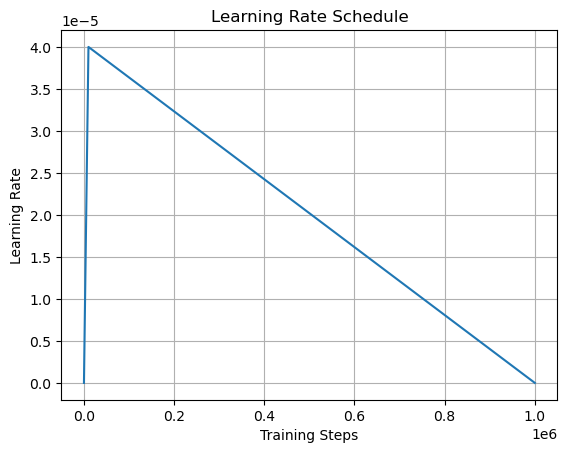

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from transformers import get_linear_schedule_with_warmup
import config

# Randomly create a model
test_model = torch.nn.Linear(10, 1)

# Create optimizer
optimizer = Adam(
    test_model.parameters(),
    lr=config.FinetuningConfig.lr,
    weight_decay=config.FinetuningConfig.weight_decay
)

# Create the learning rate scheduler using transformers' get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_training_steps=config.total_steps,  # Total number of training steps
    num_warmup_steps=config.warmup_steps,    # Number of warmup steps
)

lr_values = []

# Loop through training steps
for _ in range(config.total_steps):
    # Update lr
    optimizer.step()
    lr_values.append(scheduler.get_last_lr())
    scheduler.step()

# Plot the learning rate curve
plt.plot(lr_values)
plt.title('Learning Rate Schedule')
plt.xlabel('Training Steps')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

### 3.2 Train Loop

In [5]:
import torch
from torch.optim import AdamW,Adam
import config  
from transformers import get_linear_schedule_with_warmup
# finetune
pad_idx = 0
def split_batch(batch):  
    tokens, attention_mask, labels = batch 
    attention_mask = (tokens != pad_idx).long() 
    input_ids = tokens.to(device)
    attention_mask = attention_mask.to(device)
    labels = labels.to(device)
    return input_ids, attention_mask, labels

from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

@torch.no_grad()
def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(dataloader, desc="Evaluating"):
        input_ids, attention_mask, gt = split_batch(batch)

        clf_logits = model(input_ids)  # get classfier logits
        
        loss = criterion(clf_logits, gt)
        total_loss += loss.item()

        preds = torch.argmax(clf_logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(gt.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy


In [6]:
def train(epoch, model, optimizer, scheduler, dataloader):
    model.train()
    total_loss = 0
    optimizer.zero_grad()  

    for batch in tqdm(dataloader, desc=f"Training Epoch {epoch}"):
        input_ids, attention_mask, labels = split_batch(batch)
        
        # single sentence, requiring no segment info
        segment_info = torch.zeros(input_ids.size(0), input_ids.size(1))

        input_ids = input_ids.to(device).long()  
        attention_mask = attention_mask.to(device).long()  
        segment_info = segment_info.to(device).long()  
        
        
        loss, logits = model(input_ids, token_type_ids=segment_info, attention_mask=attention_mask, labels=labels)
        
        loss.backward()
        # grad-clip
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # update step and lr
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss

In [7]:
def training_loop(model, train_dataloader, valid_dataloader, optimizer, scheduler, criterion, num_epochs):
    for epoch in range(num_epochs):
        # train
        avg_train_loss = train(
            epoch + 1, model, optimizer, scheduler, train_dataloader
        )

        # valid
        avg_valid_loss, avg_acc = evaluate(model, criterion, valid_dataloader)

        print(
            f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss:.4f},",
            f"Validation Loss: {avg_valid_loss:.4f}, Accuracy: {avg_acc * 100:.2f}",
        )

        # save checkpoint
        checkpoint_path = config.checkpoint_dir / f"bert_clf_{epoch + 1}.pth"
        torch.save(
            {
                "epoch": epoch + 1,
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
            },
            checkpoint_path,
        )


# Adam optimizer
optimizer = AdamW(model.parameters(), lr=config.FinetuningConfig.lr, weight_decay=config.FinetuningConfig.weight_decay)
scheduler = get_linear_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.FinetuningConfig.warmup_steps,
    num_training_steps=len(train_dataloader) * config.FinetuningConfig.n_epoch
)
criterion = torch.nn.CrossEntropyLoss()

training_loop(model, train_dataloader, valid_dataloader, optimizer, scheduler, criterion, config.FinetuningConfig.n_epoch)

Training Epoch 1:   0%|          | 0/2105 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 1/3, Training Loss: 0.3333, Validation Loss: 0.6640, Accuracy: 52.98


Training Epoch 2:   0%|          | 0/2105 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2/3, Training Loss: 0.1657, Validation Loss: 0.3754, Accuracy: 89.33


Training Epoch 3:   0%|          | 0/2105 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3/3, Training Loss: 0.1287, Validation Loss: 0.3670, Accuracy: 90.14
